In [1]:
import os, glob
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import torch.nn as nn
import pathlib
import sys
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
import architectures as arch
from architectures.callbacks import LightningWrapper
from datasets.data_modules import DATA_MODULES
import datasets.dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH
from functools import partial
import stir.model.tools.helpers as helpers
import stir
import itertools

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# EVAL_DATASETS = ['imagenet', 'cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']
EVAL_DATASETS = ['cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']

CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robustl2eps3': \
            '/NS/robustness_3/work/vnanda/adv-robustness/logs/robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'
        },
    'vit_small_patch16_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        },
    'vit_small_patch32_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        },
}
SEED = 2
BATCH_SIZE = 100

In [3]:
class MaskedModel(nn.Module):
    def __init__(self, model, mask):
        super().__init__()
        self.mask = mask
        self.model = model
    
    def forward(self, x, *args, **kwargs):
        out, latent = self.model(x, *args, **kwargs)
        return out, latent[:,self.mask]

In [4]:
def find_chosen_neurons(m1):
    frac_to_chosen_neurons = {}
    for partial_seed in PARTIAL_CHOICE_SEEDS:
        for frac in PARTIAL_FRACTIONS:
            name, param = list(m1.model.named_modules())[-1]
            in_fts = param.in_features
            num_neurons = int(frac * in_fts)
            linear = nn.Linear(num_neurons, dsmd.DATASET_PARAMS[SOURCE_DATASET]['num_classes'])
            torch.manual_seed(partial_seed)
            chosen_neurons = torch.randperm(in_fts)[:num_neurons]

            if frac in frac_to_chosen_neurons:
                frac_to_chosen_neurons[frac].append(chosen_neurons)
            else:
                frac_to_chosen_neurons[frac] = [chosen_neurons]
    return frac_to_chosen_neurons

In [5]:
def results(SOURCE_DATASET, MODEL, APPENDS, PARTIAL_CHOICE_SEEDS, PARTIAL_FRACTIONS):
    results = []
    for eval_ds in EVAL_DATASETS:
        print (eval_ds)
        append_to_frac_ckas = {}
        dm = DATA_MODULES[eval_ds](
            data_dir=DATA_PATH_IMAGENET if 'imagenet' in eval_ds else DATA_PATH,
            transform_train=dsmd.TEST_TRANSFORMS_DEFAULT(224),
            transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
            batch_size=BATCH_SIZE)
        dm.init_remaining_attrs(eval_ds)
        for append in APPENDS:
            m1 = arch.create_model(MODEL, SOURCE_DATASET, pretrained=True,
                                   checkpoint_path=CHECKPOINT_PATHS[MODEL][append], seed=SEED, 
                                   callback=partial(LightningWrapper, 
                                                    dataset_name=SOURCE_DATASET,
                                                    inference_kwargs={'with_latent': True}))
            frac_to_chosen_neurons = find_chosen_neurons(m1)
            frac_to_ckas = {}
            for frac in PARTIAL_FRACTIONS:
                for mask1, mask2 in itertools.combinations(frac_to_chosen_neurons[frac], 2):
                    stir_score = stir.STIR(MaskedModel(m1, mask1), MaskedModel(m1, mask2), 
                        helpers.InputNormalize(dsmd.STANDARD_MEAN, dsmd.STANDARD_STD), 
                        helpers.InputNormalize(dsmd.STANDARD_MEAN, dsmd.STANDARD_STD),
                        (dm.test_dataloader(), 1000), verbose=False, layer1_num=None, 
                        layer2_num=None, no_opt=True, cka_only=True)
                    if frac in frac_to_ckas:
                        frac_to_ckas[frac].append(stir_score.rsm)
                    else:
                        frac_to_ckas[frac] = [stir_score.rsm]

            append_to_frac_ckas[append] = frac_to_ckas
        results.append(append_to_frac_ckas)
    
    plt_str = '== CKA Analysis ==\n\n'
    for idx, eval_ds in enumerate(EVAL_DATASETS):
        plt_str += f'=== {eval_ds} ===\n\n'
        for append in APPENDS:
            frac_to_ckas = results[idx][append]
            full_cka = frac_to_ckas[1.]
            remaining_cka = {k:v for k,v in frac_to_ckas.items() if k!=1}
            x_vals, y_vals = list(zip(*sorted(remaining_cka.items(), key=lambda t: t[0])))
            plt_str += '== {} ==\n\n{}\n\n'.format(
                append,
                plt_hp.get_wiki_link(plt_hp.line_plot(
                    [[np.mean(_y) for _y in y_vals]], 'Fraction of neurons', 'CKA', f'Eval On {eval_ds}', 
                    subfolder=SOURCE_DATASET, filename=f'{MODEL}-{append}-{eval_ds}', extension='png', 
                    x_vals=x_vals, 
                    legend_vals=['', 'Full Layer'], vertical_line=None, 
                    horizontal_lines=[np.mean(full_cka)], horizontal_lines_err=[np.std(full_cka)], 
                    colors=None, linestyles=['-', '--'],
                    y_lims=(0.,1.1), root_dir='.', paper_friendly_plots=False, 
                    plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
                    marker=[True], results_subfolder_name='cka_analysis', 
                    grid_spacing=None, y_err=[[np.std(_y) for _y in y_vals]], legend_ncol=None), 
                                     SERVER_PROJECT_PATH, size=1000))
    
    with open(f'./results/cka_analysis/{SOURCE_DATASET}/wiki_results-{MODEL}.txt', 'w') as fp:
        fp.write(plt_str)

    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'cka_analysis', SOURCE_DATASET)], 
            'results', SERVER_PROJECT_PATH, '.png')
    return results

In [ ]:
SOURCE_DATASET = 'imagenet'
MODEL = 'resnet50'
APPENDS = list(CHECKPOINT_PATHS[MODEL].keys())

PARTIAL_CHOICE_SEEDS = list(range(1,6))
PARTIAL_FRACTIONS = sorted(
        list(set(
            [float(x.split('/frac-')[1].split('-')[0]) for x in \
                glob.glob(f'./checkpoints/{MODEL}-base-'
                          f'{SOURCE_DATASET}-ft-{EVAL_DATASETS[-1]}/'
                          f'*-bs-256-{APPENDS[0]}')]
            )))
NUMBERS = [8,16,32,64,128,256,512,1024,2048]

results_fracs = results(SOURCE_DATASET, MODEL, APPENDS, PARTIAL_CHOICE_SEEDS, PARTIAL_FRACTIONS)
results_numbers = results(SOURCE_DATASET, MODEL, APPENDS, PARTIAL_CHOICE_SEEDS, 
                          [x/NUMBERS[-1] for x in NUMBERS])

Global seed set to 2


cifar10


/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

Global seed set to 2


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

Global seed set to 2


Not doing a second pass
cifar100


Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

Global seed set to 2


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

Global seed set to 2


Not doing a second pass
flowers


Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

Global seed set to 2


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

Global seed set to 2


Not doing a second pass
oxford-iiit-pets


Global seed set to 0


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

Global seed set to 2


Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a second pass
Not doing a seco

In [8]:
results_

[{'nonrob': {0.0: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   3.62e-06: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   1e-05: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   1.847e-05: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   3.695e-05: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   7.408e-05: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   0.0001: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   0.0001112: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   0.00018546: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   0.00029666: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   0.00033379: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   0.00037092: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   0.0005: [0.0006359749240800738,
    0.01590333692729473,
    0.0035418912302702665,
    0.001575887086801231,
    0.004272802732884884,
    0.00433059548959136,
    0.005550392437726259,
    0.008393824100

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == "__main__":
/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
../plot_helper.py:121: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  label=legend_vals[i] if legend_vals is not None else "")


[(0.0, 3.62e-06, 1e-05, 1.847e-05, 3.695e-05, 7.408e-05, 0.0001, 0.0001112, 0.00018546, 0.00029666, 0.00033379, 0.00037092, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9), (0.0, 3.62e-06, 1e-05, 1.847e-05, 3.695e-05, 7.408e-05, 0.0001, 0.0001112, 0.00018546, 0.00029666, 0.00033379, 0.00037092, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9), (0.0, 3.62e-06, 1e-05, 1.847e-05, 3.695e-05, 7.408e-05, 0.0001, 0.0001112, 0.00018546, 0.00029666, 0.00033379, 0.00037092, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9), (0.0, 3.62e-06, 1e-05, 1.847e-05, 3.695e-05, 7.408e-05, 0.0001, 0.0001112, 0.00018546, 0.00029666, 0.00033379, 0.00037092, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9)] [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.005679557693656534, 0.0315188999986276, 0.03558306060731411, 0.0573429189622402

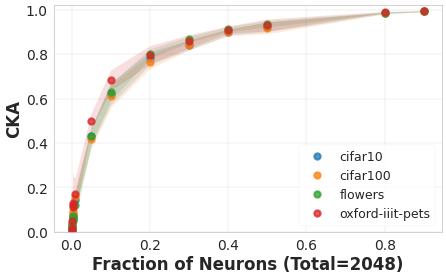

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == "__main__":
/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
../plot_helper.py:121: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  label=legend_vals[i] if legend_vals is not None else "")


[(0.0, 3.62e-06, 1e-05, 1.847e-05, 3.695e-05, 7.408e-05, 0.0001, 0.0001112, 0.00018546, 0.00029666, 0.00033379, 0.00037092, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9), (0.0, 3.62e-06, 1e-05, 1.847e-05, 3.695e-05, 7.408e-05, 0.0001, 0.0001112, 0.00018546, 0.00029666, 0.00033379, 0.00037092, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9), (0.0, 3.62e-06, 1e-05, 1.847e-05, 3.695e-05, 7.408e-05, 0.0001, 0.0001112, 0.00018546, 0.00029666, 0.00033379, 0.00037092, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9), (0.0, 3.62e-06, 1e-05, 1.847e-05, 3.695e-05, 7.408e-05, 0.0001, 0.0001112, 0.00018546, 0.00029666, 0.00033379, 0.00037092, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 0.9)] [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.010409875590448791, 0.0277059655636549, 0.06238577626645565, 0.1226809583604335

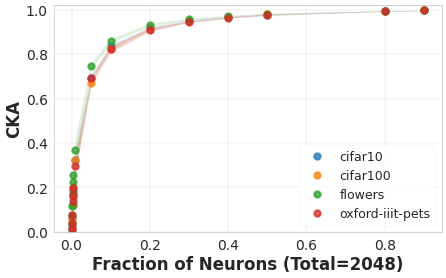

In [9]:
for append in CHECKPOINT_PATHS['resnet50'].keys():
    all_x_vals, all_y_vals= [], []
    for idx, ft_ds in enumerate(EVAL_DATASETS):
        x, y = list(zip(*sorted(
            results_fracs[idx][append].items(), key=lambda i:i[0])))
        all_x_vals.append(x[:-1])
        all_y_vals.append(y[:-1])
    plt_hp.line_plot(
        [[np.nanmean(_y) for _y in y_vals] for y_vals in all_y_vals], 
        'Fraction of Neurons (Total=2048)', 'CKA', '', 
        subfolder=SOURCE_DATASET, filename=f'{MODEL}-{append}-allds-random', 
        extension='png', x_vals=all_x_vals, legend_vals=EVAL_DATASETS, vertical_line=None, 
        colors=plt_hp.COLORS[:len(EVAL_DATASETS)], 
        linestyles=['']*len(EVAL_DATASETS), 
        y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
        marker=['o'] * len(EVAL_DATASETS), 
        results_subfolder_name='cka_analysis', grid_spacing=None, 
        y_err=[[np.nanstd(_y) for _y in y_vals] for y_vals in all_y_vals], legend_ncol=None)

In [ ]:
for append in CHECKPOINT_PATHS['resnet50'].keys():
    all_x_vals, all_y_vals= [], []
    for idx, ft_ds in enumerate(EVAL_DATASETS):
        x, y = list(zip(*sorted(
            results_fracs[idx+1][append].items(), key=lambda i:i[0])))
        all_x_vals.append(x[:-1])
        all_y_vals.append(y[:-1])
    plt_hp.line_plot(
        [[np.nanmean(_y) for _y in y_vals] for y_vals in all_y_vals], 
        'Fraction of Neurons (Total=2048)', 'CKA', '', 
        subfolder=SOURCE_DATASET, filename=f'{MODEL}-{append}-allds-random', 
        extension='png', x_vals=all_x_vals, legend_vals=EVAL_DATASETS, vertical_line=None, 
        colors=plt_hp.COLORS[:len(EVAL_DATASETS)], 
        linestyles=['']*len(EVAL_DATASETS), 
        y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
        marker=['*'] * len(EVAL_DATASETS), 
        results_subfolder_name='cka_analysis', grid_spacing=None, 
        y_err=[[np.nanstd(_y) for _y in y_vals] for y_vals in all_y_vals], legend_ncol=None)

Global seed set to 2


[0.005, 0.05, 0.1, 0.2, 0.5, 0.9, 1.0]
imagenet


Global seed set to 0
Global seed set to 2


cifar10


Global seed set to 0
Global seed set to 2


cifar100


Global seed set to 0
Global seed set to 2


flowers


Global seed set to 0
Global seed set to 2


oxford-iiit-pets


Global seed set to 0
../plot_helper.py:110: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  label=legend_vals[i] if legend_vals is not None else "")


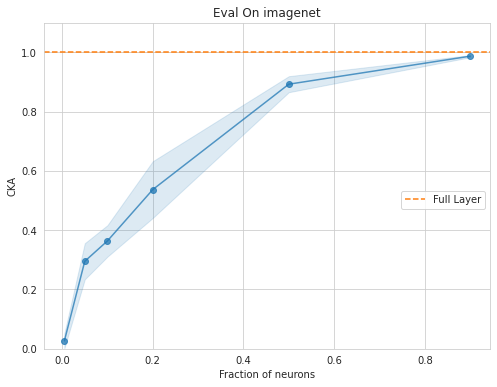

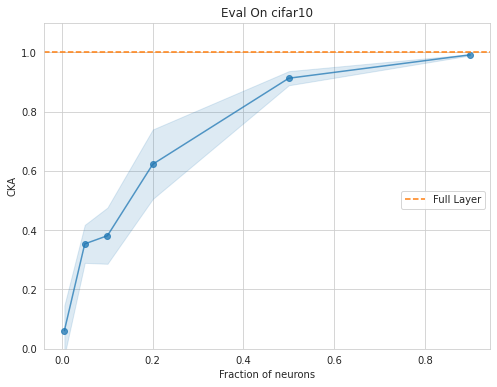

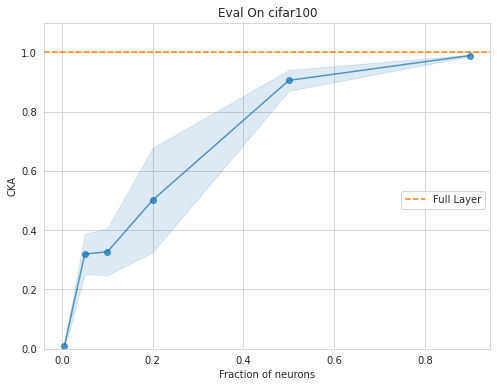

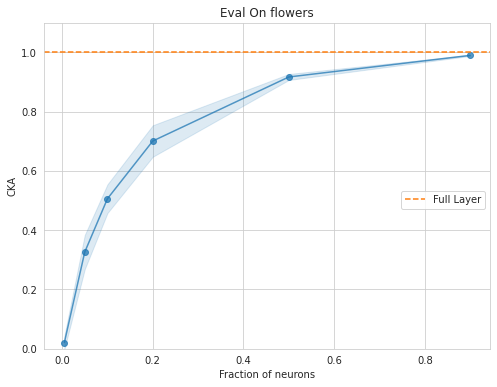

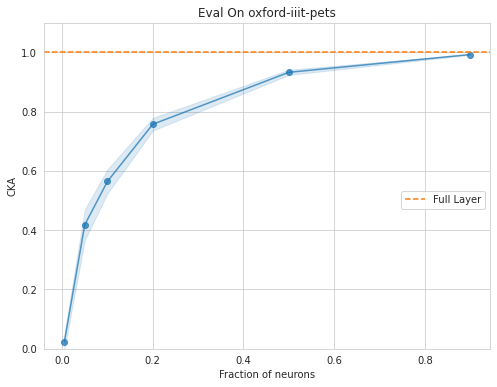

Uploading results in ['results/cka_analysis/imagenet21k'] to contact.mpi-sws.org...
Uploading 5 files to server
Created /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis/imagenet21k over sftp!
copying results/cka_analysis/imagenet21k/vit_small_patch16_224-nonrob-oxford-iiit-pets.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis/imagenet21k/vit_small_patch16_224-nonrob-oxford-iiit-pets.png
copying results/cka_analysis/imagenet21k/vit_small_patch16_224-nonrob-flowers.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis/imagenet21k/vit_small_patch16_224-nonrob-flowers.png
copying results/cka_analysis/imagenet21k/vit_small_patch16_224-nonrob-cifar10.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis/imagenet21k/vit_small_patch16_224-nonrob-cifar10.png
copying results/cka_analysis/imagenet21k/vit_small_patch16_224-nonrob-imagenet.png to /home/vnanda/public_html/results/partially_inverted_reps/ck

In [21]:
SOURCE_DATASET = 'imagenet21k'
MODEL = 'vit_small_patch16_224'
APPENDS = list(CHECKPOINT_PATHS[MODEL].keys())

PARTIAL_CHOICE_SEEDS = list(range(1,6))
PARTIAL_FRACTIONS = sorted(
        list(set(
            [float(x.split('/frac-')[1].split('-')[0]) for x in \
                glob.glob(f'./checkpoints/{MODEL}-base-'
                          f'{SOURCE_DATASET}-ft-{EVAL_DATASETS[-1]}/'
                          f'*-bs-256-{APPENDS[0]}')]
            )))
print (PARTIAL_FRACTIONS)
results(SOURCE_DATASET, MODEL, APPENDS, PARTIAL_CHOICE_SEEDS, PARTIAL_FRACTIONS)

Global seed set to 2


[0.005, 0.05, 0.1, 0.2, 0.5, 0.9, 1.0]
imagenet


Global seed set to 0
Global seed set to 2


cifar10


Global seed set to 0
Global seed set to 2


cifar100


Global seed set to 0
Global seed set to 2


flowers


Global seed set to 0
Global seed set to 2


oxford-iiit-pets


Global seed set to 0


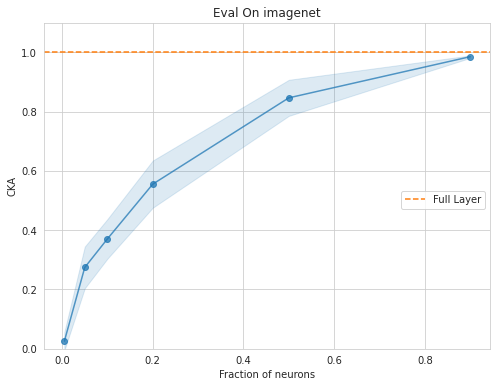

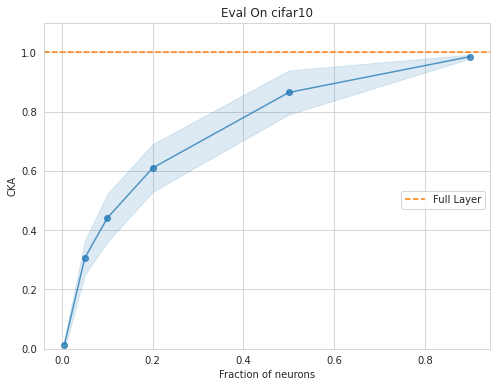

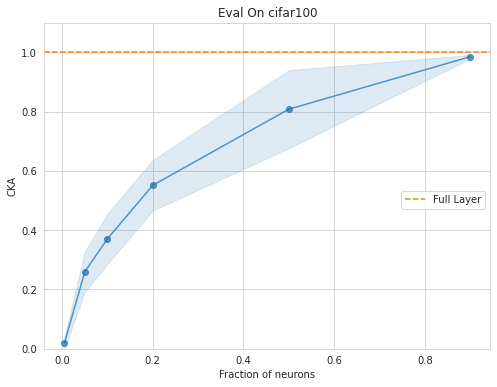

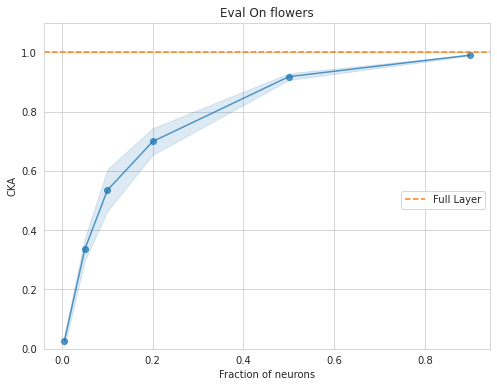

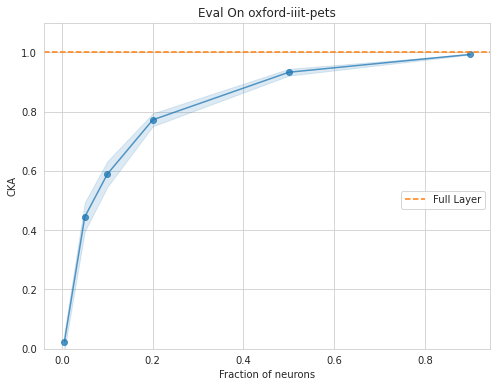

Uploading results in ['results/cka_analysis/imagenet21k'] to contact.mpi-sws.org...
Uploading 10 files to server
copying results/cka_analysis/imagenet21k/vit_small_patch16_224-nonrob-oxford-iiit-pets.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis/imagenet21k/vit_small_patch16_224-nonrob-oxford-iiit-pets.png
copying results/cka_analysis/imagenet21k/vit_small_patch16_224-nonrob-flowers.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis/imagenet21k/vit_small_patch16_224-nonrob-flowers.png
copying results/cka_analysis/imagenet21k/vit_small_patch32_224-nonrob-flowers.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis/imagenet21k/vit_small_patch32_224-nonrob-flowers.png
copying results/cka_analysis/imagenet21k/vit_small_patch32_224-nonrob-cifar10.png to /home/vnanda/public_html/results/partially_inverted_reps/cka_analysis/imagenet21k/vit_small_patch32_224-nonrob-cifar10.png
copying results/cka_analysis/imagenet

In [22]:
SOURCE_DATASET = 'imagenet21k'
MODEL = 'vit_small_patch32_224'
APPENDS = list(CHECKPOINT_PATHS[MODEL].keys())

PARTIAL_CHOICE_SEEDS = list(range(1,6))
PARTIAL_FRACTIONS = sorted(
        list(set(
            [float(x.split('/frac-')[1].split('-')[0]) for x in \
                glob.glob(f'./checkpoints/{MODEL}-base-'
                          f'{SOURCE_DATASET}-ft-{EVAL_DATASETS[-1]}/'
                          f'*-bs-256-{APPENDS[0]}')]
            )))
print (PARTIAL_FRACTIONS)
results(SOURCE_DATASET, MODEL, APPENDS, PARTIAL_CHOICE_SEEDS, PARTIAL_FRACTIONS)